In [1]:
import os
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Basisverzeichnis des Projekts
BASE_PATH = "/home/jan/studienarbeit/Studienarbeit-CODE_Semantische_Segmentation"

# Ordner, in dem die Confusion Matrices gespeichert sind (z.B. von Cityscapes)
CONF_MATRIX_DIR = os.path.join(BASE_PATH, "FINAL_DATEN/confusion_matrices_city")
print("Confusion Matrix Directory:", CONF_MATRIX_DIR)

# Cityscapes: 20 Klassen
NUM_CLASSES = 20

# Dictionary mit Klassennamen
city_classes = {
    0: 'road',
    1: 'sidewalk',
    2: 'building',
    3: 'wall',
    4: 'fence',
    5: 'pole',
    6: 'traffic light',
    7: 'traffic sign',
    8: 'vegetation',
    9: 'terrain',
    10: 'sky',
    11: 'person',
    12: 'rider',
    13: 'car',
    14: 'truck',
    15: 'bus',
    16: 'train',
    17: 'motorcycle',
    18: 'bicycle',
    19: 'unlabeled',
}


Confusion Matrix Directory: /home/jan/studienarbeit/Studienarbeit-CODE_Semantische_Segmentation/FINAL_DATEN/confusion_matrices_city


In [2]:
def compute_metrics(cm):
    """
    Berechnet verschiedene Metriken aus der übergebenen Confusion Matrix.
    
    Rückgabe:
        - mIoU: Mean Intersection over Union
        - per_class_IoU: IoU je Klasse
        - mPA: Mean Pixel Accuracy
        - per_class_PA: Pixel Accuracy je Klasse
        - mean_Dice: Mean Dice-Koeffizient
        - per_class_Dice: Dice-Koeffizient je Klasse
        - FWIoU: Frequency Weighted IoU
    """
    # Berechne Intersection, Ground Truth- und Predicted-Summen
    intersection = torch.diag(cm).float()
    ground_truth_sum = cm.sum(1).float()
    predicted_sum = cm.sum(0).float()
    
    # IoU
    union = ground_truth_sum + predicted_sum - intersection + 1e-6
    iou_per_class = intersection / union
    mIoU = torch.mean(iou_per_class).item()
    
    # Pixel Accuracy
    pixel_accuracy = intersection / (ground_truth_sum + 1e-6)
    mPA = torch.mean(pixel_accuracy).item()
    
    # Dice-Koeffizient
    dice = (2 * intersection) / (ground_truth_sum + predicted_sum + 1e-6)
    mean_dice = torch.mean(dice).item()
    
    # Frequency Weighted IoU (FWIoU)
    total_pixels = cm.sum().float() + 1e-6
    fwiou = (ground_truth_sum * iou_per_class).sum().item() / total_pixels.item()
    
    return {
        "mIoU": mIoU,
        "per_class_IoU": iou_per_class,
        "mPA": mPA,
        "per_class_PA": pixel_accuracy,
        "mean_Dice": mean_dice,
        "per_class_Dice": dice,
        "FWIoU": fwiou,
    }


In [3]:
# Suche alle .pt-Dateien im CONF_MATRIX_DIR
conf_files = glob.glob(os.path.join(CONF_MATRIX_DIR, "*_confusion_matrix.pt"))
print(f"Gefundene Confusion Matrix-Dateien: {len(conf_files)}")

# Dictionary, um die geladenen Confusion Matrices zu speichern
confusion_matrices = {}
for file in conf_files:
    model_name = os.path.basename(file).split("_confusion_matrix.pt")[0]
    cm = torch.load(file)
    confusion_matrices[model_name] = cm
    print(f"Modell: {model_name}, Matrix-Shape: {cm.shape}")

Gefundene Confusion Matrix-Dateien: 6
Modell: fcn_resnet101, Matrix-Shape: torch.Size([20, 20])
Modell: deeplabv3_resnet101, Matrix-Shape: torch.Size([20, 20])
Modell: deeplabv3_resnet50, Matrix-Shape: torch.Size([20, 20])
Modell: deeplabv3_mobilenet_v3_large, Matrix-Shape: torch.Size([20, 20])
Modell: lraspp_mobilenet_v3_large, Matrix-Shape: torch.Size([20, 20])
Modell: fcn_resnet50, Matrix-Shape: torch.Size([20, 20])


In [4]:
metrics_summary = {}

for model_name, cm in confusion_matrices.items():
    metrics = compute_metrics(cm)
    metrics_summary[model_name] = metrics

    # Berechne relative Häufigkeit pro Klasse aus der Confusion Matrix
    epsilon = 1e-6
    row_sum = cm.sum(1).float()  # Anzahl der Ground Truth-Pixel pro Klasse
    total_pixels = cm.sum().float() + epsilon
    frequency = (row_sum / total_pixels) * 100.0
    metrics_summary[model_name]["frequency_percent"] = frequency  


    print(f"\nModell: {model_name}")
    print(f"Mean IoU: {metrics['mIoU']:.4f}")
    #print(f"Mean Pixel Accuracy: {metrics['mPA']:.4f}")
    print(f"FWIoU: {metrics['FWIoU']:.4f}")
    #print(f"Mean Dice: {metrics['mean_Dice']:.4f}")
    print("\nPer-Klassen Metriken:")
    print("{:<12} {:<40} {:>10} {:>15}".format("Class Index", "Class Name", "IoU", "Frequency (%)"))
    print("-"*70)
    for i in range(NUM_CLASSES):
        class_name = city_classes.get(i, f"Class {i}")
        print("{:<12} {:<40} {:>10.4f} {:>15.2f}".format(
            i,
            class_name,
            metrics['per_class_IoU'][i].item(),
            frequency[i].item()
        ))



Modell: fcn_resnet101
Mean IoU: 0.6305
FWIoU: 0.8298

Per-Klassen Metriken:
Class Index  Class Name                                      IoU   Frequency (%)
----------------------------------------------------------------------
0            road                                         0.9343           32.62
1            sidewalk                                     0.7237            5.12
2            building                                     0.8514           19.85
3            wall                                         0.4439            0.50
4            fence                                        0.4660            0.67
5            pole                                         0.2802            1.12
6            traffic light                                0.4406            0.18
7            traffic sign                                 0.5464            0.50
8            vegetation                                   0.8637           14.04
9            terrain                      

In [5]:
OUTPUT_JSON_PATH = os.path.join("FINAL_DATEN", "evaluation_metrics_city.json")
# Konvertiere Tensor-Metriken in Listen
def tensor_metrics_to_list(metrics):
    converted = {}
    for key, value in metrics.items():
        if isinstance(value, torch.Tensor):
            converted[key] = value.cpu().tolist()
        else:
            converted[key] = value
    return converted

metrics_summary_json = {model: tensor_metrics_to_list(metrics) for model, metrics in metrics_summary.items()}

with open(OUTPUT_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(metrics_summary_json, f, indent=4)
print(f"\nEvaluationsmetriken wurden in JSON gespeichert: {OUTPUT_JSON_PATH}")



Evaluationsmetriken wurden in JSON gespeichert: FINAL_DATEN/evaluation_metrics_city.json


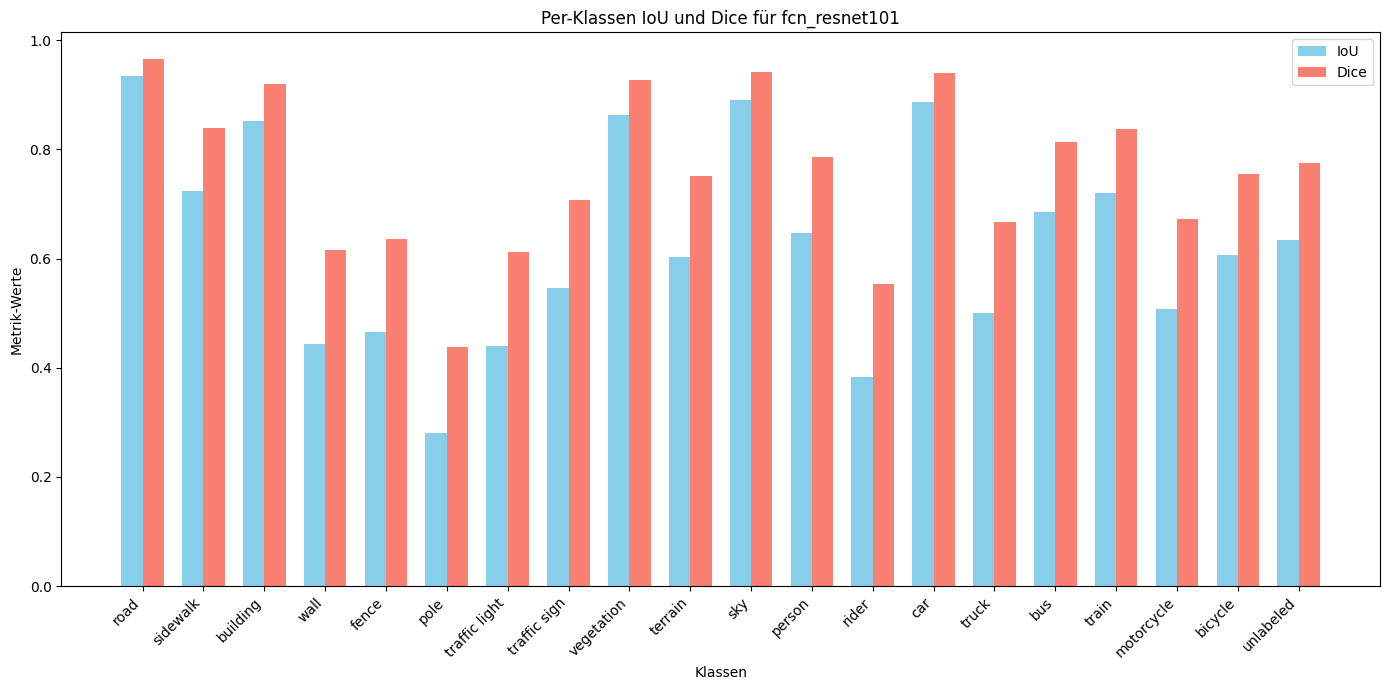

In [6]:
if len(metrics_summary) > 0:
    first_model = list(metrics_summary.keys())[0]
    metrics = metrics_summary[first_model]
    iou_values = metrics['per_class_IoU'].cpu().numpy()
    dice_values = metrics['per_class_Dice'].cpu().numpy()
    
    indices = np.arange(NUM_CLASSES)
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 7))
    bars1 = ax.bar(indices - width/2, iou_values, width, label='IoU', color='skyblue')
    bars2 = ax.bar(indices + width/2, dice_values, width, label='Dice', color='salmon')
    
    ax.set_xlabel("Klassen")
    ax.set_ylabel("Metrik-Werte")
    ax.set_title(f"Per-Klassen IoU und Dice für {first_model}")
    ax.set_xticks(indices)
    ax.set_xticklabels([city_classes.get(i, f"Class {i}") for i in range(NUM_CLASSES)], rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.show()